<a href="https://colab.research.google.com/github/Arpitkamal/Sequences-Time-Series-and-Prediction/blob/master/S%2BP_Week_4_Sunspot_full_data_set_with_CNN%2BLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
print(tf.__version__)

2.2.0-rc1


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [0]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-03-27 08:57:19--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.01s   

2020-03-27 08:57:19 (4.74 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



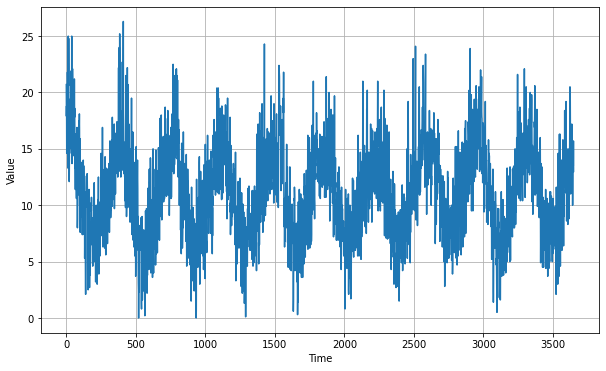

In [0]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1


series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]


window_size = 30
batch_size = 32
shuffle_buffer_size = 1000



In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
         tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
         tf.keras.layers.LSTM(64, return_sequences=True),
         tf.keras.layers.LSTM(64, return_sequences=True),
         tf.keras.layers.Dense(30, activation="relu"),
         tf.keras.layers.Dense(10, activation="relu"),
         tf.keras.layers.Dense(1),
         tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])




<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 0s 22ms/step - loss: 31.1706 - mae: 31.6550 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 0s 23ms/step - loss: 30.5228 - mae: 31.0756 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 0s 22ms/step - loss: 29.6681 - mae: 30.1801 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 0s 22ms/step - loss: 28.6311 - mae: 29.0586 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 0s 23ms/step - loss: 27.1851 - mae: 27.6945 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 0s 23ms/step - loss: 25.5238 - mae: 25.9986 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 0s 24ms/step - loss: 23.2871 - mae: 23.8429 - lr: 1.9953e-08
Epoch 8/100
10/10 [==============================] - 0s 24ms/step - loss: 20.5082 - mae: 21.1108 - l

(1e-08, 0.0001, 0.0, 60.0)

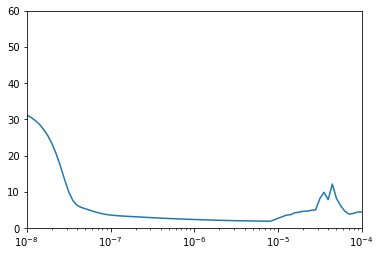

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=200, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
          tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
          tf.keras.layers.LSTM(60, return_sequences=True),
          tf.keras.layers.LSTM(60, return_sequences=True),
          tf.keras.layers.Dense(30, activation="relu"),
          tf.keras.layers.Dense(10, activation="relu"),
          tf.keras.layers.Dense(1),
          tf.keras.layers.Lambda(lambda x: x * 400) 
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)
                                    


ERROR! Session/line number was not unique in database. History logging moved to new session 59
Epoch 1/150
13/13 [==============================] - 0s 18ms/step - loss: 13.9252 - mae: 15.0428
Epoch 2/150
13/13 [==============================] - 0s 20ms/step - loss: 6.2214 - mae: 6.8365
Epoch 3/150
13/13 [==============================] - 0s 20ms/step - loss: 3.5018 - mae: 4.0435
Epoch 4/150
13/13 [==============================] - 0s 20ms/step - loss: 2.4075 - mae: 2.8808
Epoch 5/150
13/13 [==============================] - 0s 22ms/step - loss: 2.1060 - mae: 2.5693
Epoch 6/150
13/13 [==============================] - 0s 19ms/step - loss: 2.0323 - mae: 2.4908
Epoch 7/150
13/13 [==============================] - 0s 18ms/step - loss: 1.9612 - mae: 2.4209
Epoch 8/150
13/13 [==============================] - 0s 19ms/step - loss: 1.9214 - mae: 2.3829
Epoch 9/150
13/13 [==============================] - 0s 18ms/step - loss: 1.9010 - mae: 2.3592
Epoch 10/150
13/13 [============================

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

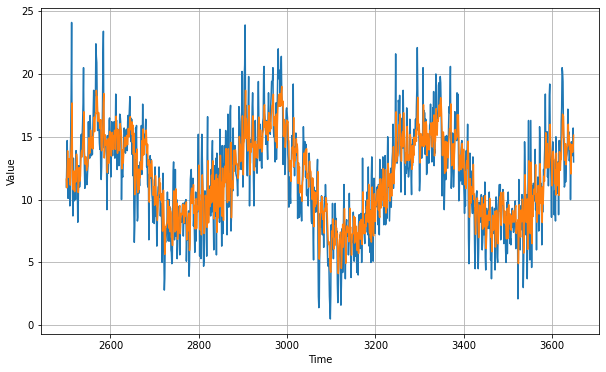

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)



In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()


1.7881579

In [0]:
print(rnn_forecast)

[11.621631  10.945869  12.4215555 ... 13.768623  13.963027  15.12559  ]
